# WG - Gesucht Data Analysis 
#### Step 3: Price Analysis

##### This notebook explores the data of the WG-Gesucht dataset. The process includes the following: 
- Looking at the average and median Rent per District in Berlin (or Suburb)
- View the extrema in each District (or Suburb)
- Compare the median rent for shared flats with general housing market in Berlin

In [288]:
import pandas as pd
import os
from datetime import datetime
from openpyxl import load_workbook
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import src.language as ln
import src.style as st
import matplotlib
import numpy as np

In [289]:
df = pd.read_parquet('Data/apartmentsBerlinDataCleaned.parquet')

# Settings
langauge = 'german'
font = {'fontname': 'Calibri'}
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Calibri"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
pd.options.mode.copy_on_write = True


### Step 1: The median Rent per District and per Suburb 

In this step, we will look at the average and median rent per suburb in Berlin.


In [290]:
df_price_analysis = df[['apartmentID', 'title', 'room_size', 'total_rent', 'suburb', 'district', 'apartment_size', 'max_roommate']]

# Clean the data and convert the columns to the right data type for calculations
df_price_analysis.loc[:, 'room_size'] = df_price_analysis['room_size'].str.replace('m²', '').astype(float)
df_price_analysis.loc[:, 'apartment_size'] = df_price_analysis['apartment_size'].str.replace('m²', '').astype(float)
df_price_analysis.loc[:, 'total_rent'] = df_price_analysis['total_rent'].str.replace('€', '').astype(float)
df_price_analysis.loc[:, 'max_roommate'] = df_price_analysis['max_roommate'].astype(float)

For the follwing, you can choose excluding the top and bottom percentages of the data.

For example 5%.  

In [291]:
# Settings:  
exclude_top_bottom_percent = True  # Set to True to exclude, or False to include all data
columns_to_trim = ['room_size', 'total_rent']
bottom_quantile = 0.02
top_quantile = 0.98

In [292]:
def trim_dataset_all_columns(df, columns, exclude_top_bottom_10percent, bottom_quantile, top_quantile):

    if exclude_top_bottom_10percent:
        conditions = [df[col].between(df[col].quantile(bottom_quantile), df[col].quantile(top_quantile)) for col in columns]
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition &= condition
        return df[combined_condition]
    else:
        return df

In [293]:
# Apply trimming across specified columns
df_price_analysis = trim_dataset_all_columns(df_price_analysis, columns_to_trim, exclude_top_bottom_percent, bottom_quantile, top_quantile)

Adjust the squaremeter price per room with the shared squaremeters by all roomates for better comparison. 

Assumption: 
- All people pay equal prizes in the apartment 
- Each person has same roomsize
- Resulting in a shared space calculated by apartment size subtracted by people living the apartment times average room size. 

In [294]:
# Calculating mean room size 
average_room_size = df_price_analysis['room_size'].mean()

# Filter only the ads where the apartment size is available
df_price_analysis_adjusted = df_price_analysis[df_price_analysis['apartment_size'].notnull()]

In [295]:
df_price_analysis_adjusted.loc[:, 'room_size_per_person'] = df_price_analysis['room_size'].mean()

df_price_analysis_adjusted.loc[:, 'room_size_per_person'] = np.where(
    df_price_analysis_adjusted['room_size'] < (2/3) * df_price_analysis_adjusted['room_size_per_person'],
    df_price_analysis_adjusted['room_size'],
    df_price_analysis_adjusted['room_size_per_person']
)

(2/3)*df_price_analysis['room_size'].mean()

15.46952479338843

In [296]:
# Calculate the adjusted room size
df_price_analysis_adjusted.loc[:, 'adjusted_roomsize_in_m2'] = df_price_analysis_adjusted['room_size'] + (((df_price_analysis_adjusted['apartment_size'] - df_price_analysis_adjusted['room_size']) - (df_price_analysis_adjusted['room_size_per_person'] * (df_price_analysis_adjusted['max_roommate']-1)))/df_price_analysis_adjusted['max_roommate'])

# Ensuring adjusted_roomsize_in_m2 is not smaller than the actual room_size
df_price_analysis_adjusted['adjusted_roomsize_in_m2'] = np.where(
    df_price_analysis_adjusted['adjusted_roomsize_in_m2'] < df_price_analysis_adjusted['room_size'],
    df_price_analysis_adjusted['room_size'],
    df_price_analysis_adjusted['adjusted_roomsize_in_m2']
)

# Filter negative values out 
df_price_analysis_adjusted = df_price_analysis_adjusted[df_price_analysis_adjusted['adjusted_roomsize_in_m2'] >= 0]

df_price_analysis_adjusted.loc[:, 'adjusted_price_per_m2'] = df_price_analysis_adjusted['total_rent'] / df_price_analysis_adjusted['adjusted_roomsize_in_m2']

In [297]:
df_price_analysis.loc[:, 'price_per_m2'] = df_price_analysis['total_rent'] / df_price_analysis['room_size']

In [298]:
print(f'The length of the original dataset is: {len(df_price_analysis)}')
print(f'The length of the adjusted dataset is: {len(df_price_analysis_adjusted)}')

The length of the original dataset is: 7744
The length of the adjusted dataset is: 4825


The mean and median square meter rent in the berlin Suburbs or Districts: 

In [299]:
# What do you want to analyze? 

area = 'district' # or suburb 

In [300]:
# For the original and adjusted dataframe, calculating mean and median of price per m2 by suburb
df_price_group = df_price_analysis.groupby(area).agg({'price_per_m2': ['mean', 'median']}).reset_index()

df_price_adjusted_group = df_price_analysis_adjusted.groupby(area).agg({'adjusted_price_per_m2': ['mean', 'median']}).reset_index()

In [301]:
# Renaming the columns for clarity
df_price_group.columns = [area, 'price_per_m2_mean', 'price_per_m2_median']
df_price_adjusted_group.columns = [area, 'adjusted_price_per_m2_mean', 'adjusted_price_per_m2_median']

In [302]:
df_price_group = df_price_group.sort_values('district', ascending=True)

st.display_as_table(df_price_group) 

,district,price_per_m2_mean,price_per_m2_median
0,Charlottenburg-Wilmersdorf,30.194853,27.888889
1,Friedrichshain-Kreuzberg,28.699243,27.5
2,Lichtenberg,30.046447,29.25
3,Marzahn-Hellersdorf,29.443639,29.411765
4,Mitte,30.264474,28.26087
5,Neukölln,26.915998,26.0
6,Pankow,29.307811,28.26087
7,Reinickendorf,30.904396,30.0
8,Spandau,31.531563,29.62963
9,Steglitz-Zehlendorf,29.775849,30.0


In [303]:
df_price_group = df_price_group.sort_values('price_per_m2_median', ascending=False)

print(f'The district with the highest median prices:')
st.display_as_table(df_price_group.head(3))

The district with the highest median prices:


,district,price_per_m2_mean,price_per_m2_median
7,Reinickendorf,30.904396,30.0
9,Steglitz-Zehlendorf,29.775849,30.0
8,Spandau,31.531563,29.62963


<Figure size 800x400 with 0 Axes>

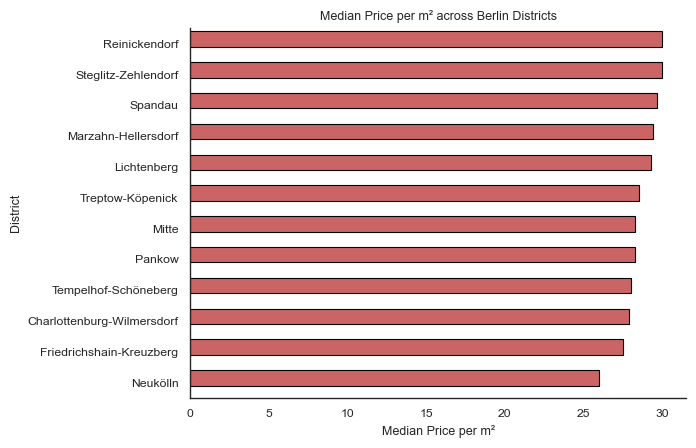

In [304]:
# Setting the style
sns.set(style="white")
sns.set_context("paper")

# Creating the figure
plt.figure(figsize=(8, 4))
fig, ax = plt.subplots()

# Creating a bar plot
sns.barplot(x='price_per_m2_median', y='district', data=df_price_group, color='#dc5454', edgecolor='black', height=0.5)

# Setting the labels and title
plt.xlabel('Median Price per m²', fontsize=9)
plt.ylabel('District', fontsize=9)
plt.title('Median Price per m² across Berlin Districts', fontsize=9)
sns.despine()

plt.show()

In [305]:
df_price_adjusted_group = df_price_adjusted_group.sort_values('district', ascending=True)

print('The highest price per m2 adjusted top 10 suburbs are:')
st.display_as_table(df_price_adjusted_group.head(10)) 

The highest price per m2 adjusted top 10 suburbs are:


,district,adjusted_price_per_m2_mean,adjusted_price_per_m2_median
0,Charlottenburg-Wilmersdorf,19.417815,18.549031
1,Friedrichshain-Kreuzberg,17.365147,16.653654
2,Lichtenberg,18.424417,17.618555
3,Marzahn-Hellersdorf,17.413378,17.138462
4,Mitte,18.76002,17.73865
5,Neukölln,17.206876,16.723607
6,Pankow,18.731964,18.223625
7,Reinickendorf,19.580516,20.0
8,Spandau,20.046521,20.184635
9,Steglitz-Zehlendorf,18.55777,18.397436


In [306]:
df_price_adjusted_group = df_price_adjusted_group.sort_values('adjusted_price_per_m2_median', ascending=False)

print('The district with the highest median prices adjusted:')
st.display_as_table(df_price_adjusted_group.head(3)) 

The district with the highest median prices adjusted:


,district,adjusted_price_per_m2_mean,adjusted_price_per_m2_median
8,Spandau,20.046521,20.184635
7,Reinickendorf,19.580516,20.0
0,Charlottenburg-Wilmersdorf,19.417815,18.549031


<Figure size 800x400 with 0 Axes>

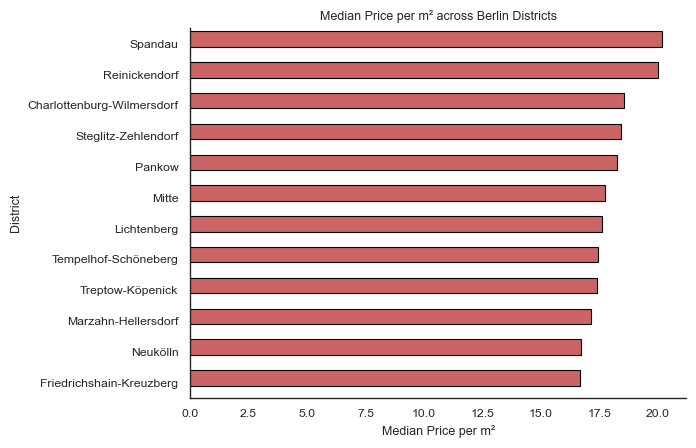

In [307]:

# Setting the style
sns.set(style="white")
sns.set_context("paper")

# Creating the figure
plt.figure(figsize=(8, 4))

fig, ax = plt.subplots()

# Creating a bar plot
sns.barplot(x='adjusted_price_per_m2_median', y='district', data=df_price_adjusted_group, color='#dc5454', edgecolor='black', height=0.5)

# Setting the labels and title
plt.xlabel('Median Price per m²', fontsize=9)
plt.ylabel('District', fontsize=9)
plt.title('Median Price per m² across Berlin Districts', fontsize=9)
sns.despine()

plt.show()

In [325]:
file_path = 'data/output/price_analysis.xlsx'
sheetnames = [f'{area}_price_per_m2', f'{area}_adjusted_price_per_m2']

# Überprüfe, ob die Datei existiert und entferne das Blatt, falls es existiert
if os.path.exists(file_path):
    workbook = load_workbook(file_path)
    for sheet_name in sheetnames:
        if sheet_name in workbook.sheetnames:
            del workbook[sheet_name]
        workbook.save(file_path)

with pd.ExcelWriter('data/output/price_analysis.xlsx', mode='a', engine='openpyxl') as writer:
    df_price_group.to_excel(writer, sheet_name=sheetnames[0])
    df_price_adjusted_group.to_excel(writer, sheet_name=sheetnames[1])

### Step 2: The extreme Ends of Rent per Squaremeter in Berlins Districts 

In this step, we will look at the maximum and minimum rent per m2 in Berlins Districts.

In [309]:
# For the original and adjusted dataframe, calculating mean and median of price per m2 by suburb
df_price_extremes_group = df_price_analysis.groupby(area).agg({'price_per_m2': ['min', 'max']}).reset_index()

df_price_adjusted_extremes_group = df_price_analysis_adjusted.groupby(area).agg({'adjusted_price_per_m2': ['min', 'max']}).reset_index()

In [310]:
# Renaming the columns for clarity
df_price_extremes_group.columns = [area, 'min', 'max']
df_price_adjusted_extremes_group.columns = [area, 'min', 'max']

For non adjusted squaremeter prices: 

In [311]:
df_price_extremes_group = df_price_extremes_group.sort_values('max', ascending=False)

print(f'The highest price per m2 top 10 {area} are:')
st.display_as_table(df_price_extremes_group[['district', 'max']].head(10)) 

The highest price per m2 top 10 district are:


,district,max
4,Mitte,110.0
0,Charlottenburg-Wilmersdorf,105.0
2,Lichtenberg,100.0
6,Pankow,100.0
1,Friedrichshain-Kreuzberg,85.0
5,Neukölln,81.142857
11,Treptow-Köpenick,74.2
7,Reinickendorf,70.0
8,Spandau,63.636364
10,Tempelhof-Schöneberg,63.333333


In [312]:
df_price_extremes_group = df_price_extremes_group.sort_values('min', ascending=True)

print(f'The min price per m2 top 10 {area} are:')
st.display_as_table(df_price_extremes_group[['district', 'min']].head(10)) 

The min price per m2 top 10 district are:


,district,min
5,Neukölln,0.7
0,Charlottenburg-Wilmersdorf,0.8125
1,Friedrichshain-Kreuzberg,0.875
10,Tempelhof-Schöneberg,0.875
4,Mitte,0.909091
3,Marzahn-Hellersdorf,0.925926
11,Treptow-Köpenick,0.95
6,Pankow,1.0
2,Lichtenberg,1.375
9,Steglitz-Zehlendorf,1.423077


For adjusted squaremeter prices: 

In [313]:
df_price_adjusted_extremes_group = df_price_adjusted_extremes_group.sort_values('max', ascending=False)

print(f'The highest price per m2 top 10 {area} are:')
st.display_as_table(df_price_adjusted_extremes_group[['district', 'max']].head(10)) 

The highest price per m2 top 10 district are:


,district,max
11,Treptow-Köpenick,65.0
4,Mitte,62.857143
6,Pankow,61.818182
10,Tempelhof-Schöneberg,59.375
1,Friedrichshain-Kreuzberg,46.0
2,Lichtenberg,45.459208
7,Reinickendorf,45.0
5,Neukölln,43.6875
0,Charlottenburg-Wilmersdorf,42.850149
8,Spandau,42.332844


In [314]:
df_price_adjusted_extremes_group = df_price_adjusted_extremes_group.sort_values('min', ascending=True)

print(f'The min price per m2 top 10 {area} are:')
st.display_as_table(df_price_adjusted_extremes_group[['district', 'min']].head(10)) 

The min price per m2 top 10 district are:


,district,min
4,Mitte,0.532352
6,Pankow,0.584328
8,Spandau,0.589416
1,Friedrichshain-Kreuzberg,0.660082
11,Treptow-Köpenick,0.736842
5,Neukölln,0.767677
10,Tempelhof-Schöneberg,0.881099
2,Lichtenberg,1.025641
0,Charlottenburg-Wilmersdorf,1.666667
7,Reinickendorf,1.899615


In [315]:
with pd.ExcelWriter('data/output/price_analysis.xlsx') as writer:
    df_price_extremes_group.to_excel(writer, sheet_name=f'{area}_price_per_m2_extremes')
    df_price_adjusted_extremes_group.to_excel(writer, sheet_name=f'{area}_adjusted_price_per_m2_extremes')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


### Step 3: Comparison of the median rent in shared flats with the general housing market 

In this step, we will compare the median rent from the berlin districts with the rents of the general housing market in Berlin 

To generate the median rents for 2024, we'll first calculate the annual percentage increase in rent. This involves determining the rate at which rents have grown year over year and applying this growth rate to forecast the median rents for 2024.

In [316]:
path = 'data/input'
years = range(2012, 2023)

dataframes = []

for year in years:
    file_path = os.path.join(path, f'Angebotsmieten_Berlin_Bezirke_{year}.csv')
    if os.path.exists(file_path):
        df_year = pd.read_csv(file_path, sep=',', usecols=[0, 1])
        df_year = df_year.rename(columns={df_year.columns[1]: str(year)})  # Rename the second column to the year
        dataframes.append(df_year)

df_district_median_rental_prices = pd.concat(dataframes, axis=1)
df_district_median_rental_prices = df_district_median_rental_prices.loc[:, ~df_district_median_rental_prices.columns.duplicated()]  # Remove duplicate columns

df_district_median_rental_prices = df_district_median_rental_prices.rename(columns={'Bezirk' : 'district'})

df_district_median_rental_prices.head()

,district,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Mitte,8.03,9.39,9.36,10.06,10.51,12.77,12.51,13.45,13.70,14.00,15.46
1,Friedrichshain-Kreuzberg,8.61,9.64,9.98,10.99,11.50,12.50,12.94,13.01,13.11,13.52,14.85
2,Pankow,8.00,8.56,8.99,9.45,9.99,10.86,10.97,10.96,10.50,11.73,12.50
3,Charlottenburg-Wilmersdorf,8.93,9.86,9.49,10.00,10.53,11.86,12.00,12.63,12.38,13.29,15.00
4,Spandau,5.93,6.48,6.58,6.99,7.35,7.95,8.59,8.86,8.53,8.22,8.67


Create a dataframe that captures of the yearly increase in rent for each district

In [317]:
years = range(2012, 2022)

df_yearly_increase = pd.DataFrame()
df = df_district_median_rental_prices
df_yearly_increase['district'] = df['district']


for i in range(len(years) - 1):
    year = years[i]
    next_year = years[i + 1]
    df_yearly_increase[f'{year}-{next_year}'] = ((df[str(next_year)] - df[str(year)]) / df[str(year)]) * 100

df_yearly_increase['Average_Increase'] = df_yearly_increase.iloc[:, 1:].mean(axis=1)

In [318]:
df_yearly_increase['Average_Increase'] = df_yearly_increase['Average_Increase'] / 100

# Add the forecasted 2023 and 2024 rents to the original df_combined DataFrame
df['2023'] = df_district_median_rental_prices['2022'] * (1 + df_yearly_increase['Average_Increase'].values)
df['2024'] = df_district_median_rental_prices['2023'] * (1 + df_yearly_increase['Average_Increase'].values)

df_median_rental_price_2024 = df[['district', '2024']]

df_median_rental_price_2024

,district,2024
0,Mitte,17.575338
1,Friedrichshain-Kreuzberg,16.438139
2,Pankow,13.635863
3,Charlottenburg-Wilmersdorf,16.424575
4,Spandau,9.341384
5,Steglitz-Zehlendorf,13.238488
6,Tempelhof-Schöneberg,12.139936
7,Neukölln,11.526679
8,Treptow-Köpenick,13.029115
9,Marzahn-Hellersdorf,10.367822


Explanation of the Ending of the Variables: 
- sf - shared flats
- ghm - general housing market  

In [319]:
df_comparison = pd.merge(df_price_group, df_price_adjusted_group, on='district', how='inner')
df_comparison = pd.merge(df_comparison, df_median_rental_price_2024, on='district')

df_comparison = df_comparison.rename(columns={
    'district': 'District',
    'price_per_m2_median': 'Price_SharedFlats', 
    'adjusted_price_per_m2_median': 'Price_Adjusted_SharedFlats',
    '2024': 'Price_HousingMarket'})

df_comparison.drop(columns=['price_per_m2_mean', 'adjusted_price_per_m2_mean'], inplace=True)

# Now df_comparison will have columns for original and adjusted median prices from both df_price_group and df_price_adjusted_group, alongside the median rental prices from df_district_median_rental_prices
# You can add calculation columns to directly compare these, for example:
df_comparison['Diff_SharedFlats_vs_HousingMarket'] = df_comparison['Price_SharedFlats'] - df_comparison['Price_HousingMarket']
df_comparison['Diff_SharedFlats_Adjusted_vs_HousingMarket'] = df_comparison['Price_Adjusted_SharedFlats'] - df_comparison['Price_HousingMarket']

In [320]:
# Calculating the percentage differences for Original and Adjusted Prices vs. Housing Market
df_comparison['Diff_Original_%'] = ((df_comparison['Price_SharedFlats'] - df_comparison['Price_HousingMarket']) / df_comparison['Price_HousingMarket']) * 100
df_comparison['Diff_Adjusted_%'] = ((df_comparison['Price_Adjusted_SharedFlats'] - df_comparison['Price_HousingMarket']) / df_comparison['Price_HousingMarket']) * 100

In [321]:
df_comparison = df_comparison.sort_values('Diff_Original_%', ascending=False)

print('The highest difference in price per m2 from shared flats to housing market are:')
st.display_as_table(df_comparison[['District', 'Price_SharedFlats', 'Price_HousingMarket', 'Diff_SharedFlats_vs_HousingMarket','Diff_Original_%']])

The highest difference in price per m2 from shared flats to housing market are:


,District,Price_SharedFlats,Price_HousingMarket,Diff_SharedFlats_vs_HousingMarket,Diff_Original_%
2,Spandau,29.62963,9.341384,20.288245,217.186716
0,Reinickendorf,30.0,10.472163,19.527837,186.473777
3,Marzahn-Hellersdorf,29.411765,10.367822,19.043943,183.683159
4,Lichtenberg,29.25,11.117928,18.132072,163.08859
8,Tempelhof-Schöneberg,28.0,12.139936,15.860064,130.64372
1,Steglitz-Zehlendorf,30.0,13.238488,16.761512,126.611983
11,Neukölln,26.0,11.526679,14.473321,125.563672
5,Treptow-Köpenick,28.535714,13.029115,15.5066,119.014989
7,Pankow,28.26087,13.635863,14.625006,107.253982
9,Charlottenburg-Wilmersdorf,27.888889,16.424575,11.464314,69.79976


In [322]:
df_comparison = df_comparison.sort_values('Diff_Adjusted_%', ascending=False)

print('The highest difference in price per m2 adjusted from shared flats to housing market are:')
st.display_as_table(df_comparison[['District', 'Price_Adjusted_SharedFlats', 'Price_HousingMarket', 'Diff_SharedFlats_Adjusted_vs_HousingMarket','Diff_Adjusted_%']])

The highest difference in price per m2 adjusted from shared flats to housing market are:


,District,Price_Adjusted_SharedFlats,Price_HousingMarket,Diff_SharedFlats_Adjusted_vs_HousingMarket,Diff_Adjusted_%
2,Spandau,20.184635,9.341384,10.843251,116.077563
0,Reinickendorf,20.0,10.472163,9.527837,90.982518
3,Marzahn-Hellersdorf,17.138462,10.367822,6.77064,65.304359
4,Lichtenberg,17.618555,11.117928,6.500627,58.46977
11,Neukölln,16.723607,11.526679,5.196928,45.086084
8,Tempelhof-Schöneberg,17.432512,12.139936,5.292576,43.596408
1,Steglitz-Zehlendorf,18.397436,13.238488,5.158948,38.969314
7,Pankow,18.223625,13.635863,4.587761,33.644819
5,Treptow-Köpenick,17.366384,13.029115,4.337269,33.289056
9,Charlottenburg-Wilmersdorf,18.549031,16.424575,2.124456,12.934615


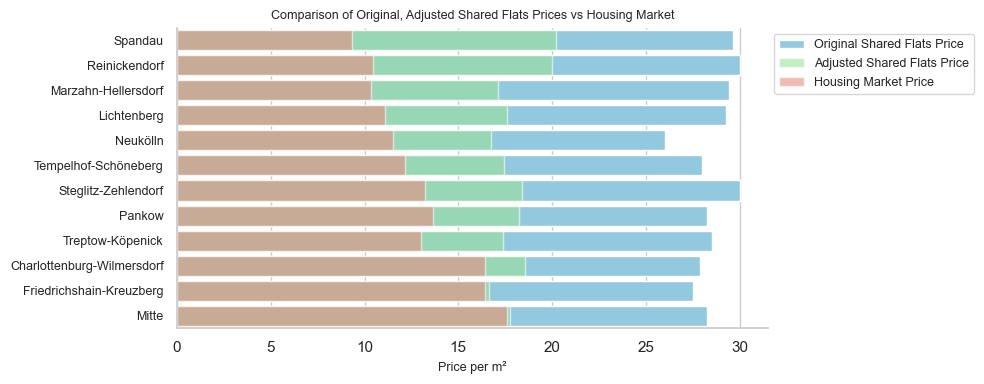

In [323]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting up the style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))

# Plotting Original Prices
sns.barplot(x='Price_SharedFlats', y='District', data=df_comparison, color='skyblue', label='Original Shared Flats Price')

# Plotting Adjusted Prices
sns.barplot(x='Price_Adjusted_SharedFlats', y='District', data=df_comparison, color='lightgreen', alpha=0.6, label='Adjusted Shared Flats Price')

# Plotting Housing Market Prices
sns.barplot(x='Price_HousingMarket', y='District', data=df_comparison, color='salmon', alpha=0.6, label='Housing Market Price')

plt.title('Comparison of Original, Adjusted Shared Flats Prices vs Housing Market', fontsize=9)
plt.xlabel('Price per m²', fontsize=9)
plt.ylabel('', fontsize=9)

# Reduce the font size of the districts (y tick labels) to 9
plt.yticks(fontsize=9)

# Move the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()


In [324]:
with pd.ExcelWriter('data/output/price_analysis.xlsx') as writer:
    df_comparison.to_excel(writer, sheet_name='price_comparison')
    